### Simplified prototype for generating documents

🎨 Visualizing graph...


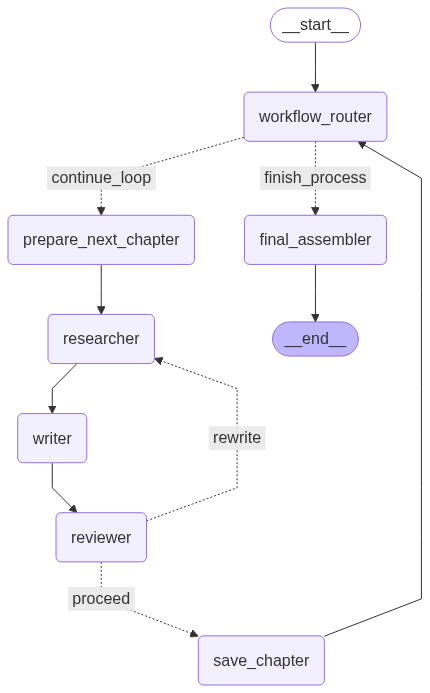


🚀 Starting Document Generation Process...
⏰ Start time: 2025-06-23 11:57:03

--- 🗺️ ROUTING: Master Router ---
  - Decision: Chapters remaining. Continue generation loop.

--- 📋 PREPARING NEXT CHAPTER ---
  - Processing Chapter ID: 1 - Introduction to Model Validation

--- 🧑‍🔬 EXECUTING RESEARCHER NODE ---

💰 Researcher Token Usage:
  - Prompt tokens: 54
  - Completion tokens: 881
  - Total tokens: 935
  - Input cost: $0.000008
  - Output cost: $0.000529
  - Total cost: $0.000537

--- ✍️ EXECUTING WRITER NODE ---

💰 Writer Token Usage:
  - Prompt tokens: 933
  - Completion tokens: 732
  - Total tokens: 1,665
  - Input cost: $0.000140
  - Output cost: $0.000439
  - Total cost: $0.000579
  - Writer Generated Text (Full):
  """
# Chapter: Introduction to Model Validation

Model validation is a fundamental aspect of risk management within financial institutions, serving as a safeguard against the potential pitfalls associated with reliance on quantitative models for decision-making. As fi

In [11]:
import os
from typing import TypedDict, List, Dict, Optional, Tuple
from pprint import pprint
from datetime import datetime
from pathlib import Path

# --- Core LangGraph and LangChain Imports ---
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# ===============================================================
# 1. SETUP: LLM AND PRICING
# ===============================================================
# The OPENAI_API_KEY is assumed to be provided automatically.
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)

# Token pricing for gpt-4o-mini (in USD per 1K tokens)
PRICING = {
    "gpt-4o-mini": {
        "input": 0.00015,   # $0.00015 per 1K input tokens
        "output": 0.0006    # $0.0006 per 1K output tokens
    }
}

# ===============================================================
# 2. STATE DEFINITION
# ===============================================================
class TokenUsage(TypedDict):
    prompt_tokens: int
    completion_tokens: int
    total_tokens: int
    input_cost: float
    output_cost: float
    total_cost: float

class ChapterWork(TypedDict):
    chapter_details: Dict
    research_results: Optional[str]
    generated_text: Optional[str]
    review_feedback: Optional[str]
    review_decision: Optional[str]
    token_usage: Dict[str, TokenUsage]  # Track tokens for each operation

class GraphState(TypedDict):
    outline: Dict
    chapters_to_process: List[Dict]
    chapter_works: Dict[str, ChapterWork]
    current_chapter_id: Optional[str]
    completed_chapters: Dict[str, Dict]
    final_document: Optional[str]
    total_token_usage: TokenUsage  # Track overall token usage
    token_log: List[Dict]  # Detailed log of all token usage

# ===============================================================
# 3. TOKEN TRACKING UTILITIES
# ===============================================================

def calculate_cost(prompt_tokens: int, completion_tokens: int, model: str = "gpt-4o-mini") -> Tuple[float, float, float]:
    """Calculate the cost based on token usage"""
    input_cost = (prompt_tokens / 1000) * PRICING[model]["input"]
    output_cost = (completion_tokens / 1000) * PRICING[model]["output"]
    total_cost = input_cost + output_cost
    return input_cost, output_cost, total_cost

def create_token_usage(prompt_tokens: int, completion_tokens: int) -> TokenUsage:
    """Create a TokenUsage dictionary"""
    input_cost, output_cost, total_cost = calculate_cost(prompt_tokens, completion_tokens)
    return {
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": prompt_tokens + completion_tokens,
        "input_cost": input_cost,
        "output_cost": output_cost,
        "total_cost": total_cost
    }

def update_total_tokens(state: GraphState, new_usage: TokenUsage, operation: str, chapter_id: str) -> Dict:
    """Update the total token usage in state"""
    total_usage = state.get("total_token_usage", create_token_usage(0, 0))
    
    # Update totals
    total_usage["prompt_tokens"] += new_usage["prompt_tokens"]
    total_usage["completion_tokens"] += new_usage["completion_tokens"]
    total_usage["total_tokens"] += new_usage["total_tokens"]
    total_usage["input_cost"] += new_usage["input_cost"]
    total_usage["output_cost"] += new_usage["output_cost"]
    total_usage["total_cost"] += new_usage["total_cost"]
    
    # Add to token log
    token_log = state.get("token_log", [])
    token_log.append({
        "timestamp": datetime.now().isoformat(),
        "operation": operation,
        "chapter_id": chapter_id,
        "usage": new_usage
    })
    
    return {
        "total_token_usage": total_usage,
        "token_log": token_log
    }

def print_token_usage(usage: TokenUsage, label: str = "Token Usage"):
    """Pretty print token usage"""
    print(f"\n💰 {label}:")
    print(f"  - Prompt tokens: {usage['prompt_tokens']:,}")
    print(f"  - Completion tokens: {usage['completion_tokens']:,}")
    print(f"  - Total tokens: {usage['total_tokens']:,}")
    print(f"  - Input cost: ${usage['input_cost']:.6f}")
    print(f"  - Output cost: ${usage['output_cost']:.6f}")
    print(f"  - Total cost: ${usage['total_cost']:.6f}")

# ===============================================================
# 4. NODE AND ROUTING FUNCTIONS (UPDATED WITH TOKEN TRACKING)
# ===============================================================

def prepare_next_chapter(state: GraphState) -> dict:
    """Prepare the next chapter for processing"""
    print("\n--- 📋 PREPARING NEXT CHAPTER ---")
    chapters_to_process = state["chapters_to_process"]
    
    if chapters_to_process:
        next_chapter = chapters_to_process[0]
        chapter_id = next_chapter["id"]
        
        # Initialize ChapterWork for this chapter if it doesn't exist
        chapter_works = state.get("chapter_works", {})
        if chapter_id not in chapter_works:
            chapter_works[chapter_id] = {
                "chapter_details": next_chapter,
                "research_results": None,
                "generated_text": None,
                "review_feedback": None,
                "review_decision": None,
                "token_usage": {}  # Initialize token usage tracking
            }
        
        print(f"  - Processing Chapter ID: {chapter_id} - {next_chapter['heading_label']}")
        
        return {
            "chapters_to_process": chapters_to_process[1:],
            "current_chapter_id": chapter_id,
            "chapter_works": chapter_works
        }
    return {}

def researcher(state: GraphState) -> dict:
    print("\n--- 🧑‍🔬 EXECUTING RESEARCHER NODE ---")
    chapter_id = state["current_chapter_id"]
    chapter_works = state["chapter_works"]
    current_work = chapter_works[chapter_id]
    current_chapter = current_work["chapter_details"]
    feedback = current_work.get("review_feedback")
    
    if feedback and current_work.get("review_decision") == "reject":
        print(f"  - Incorporating review feedback into research: {feedback}")
        topics = list(current_chapter.get("key_topics", [])) + [feedback]
    else:
        topics = current_chapter.get("key_topics", []) + current_chapter.get("keywords", [])
    
    # Create research prompt
    research_prompt = f"""
    Conduct comprehensive research on the following topics for the chapter '{current_chapter['heading_label']}':
    Topics: {', '.join(set(topics))}
    
    Provide detailed summaries for each topic that will be useful for writing the chapter.
    """
    
    # Call LLM and track tokens
    response = llm.invoke(research_prompt)
    research_summary = response.content
    
    # Extract token usage from response
    usage_metadata = response.response_metadata.get("token_usage", {})
    prompt_tokens = usage_metadata.get("prompt_tokens", 0)
    completion_tokens = usage_metadata.get("completion_tokens", 0)
    
    # Create token usage record
    token_usage = create_token_usage(prompt_tokens, completion_tokens)
    print_token_usage(token_usage, "Researcher Token Usage")
    
    # Update chapter work
    chapter_works[chapter_id]["research_results"] = research_summary
    chapter_works[chapter_id]["token_usage"]["researcher"] = token_usage
    
    # Update total tokens
    token_updates = update_total_tokens(state, token_usage, "researcher", chapter_id)
    
    return {
        "chapter_works": chapter_works,
        **token_updates
    }

def writer(state: GraphState) -> dict:
    print("\n--- ✍️ EXECUTING WRITER NODE ---")
    chapter_id = state["current_chapter_id"]
    chapter_works = state["chapter_works"]
    current_work = chapter_works[chapter_id]
    current_chapter = current_work["chapter_details"]
    research = current_work["research_results"]
    feedback_prompt = ""
    
    if current_work.get("review_decision") == "reject":
        feedback_prompt = f"Please address the following feedback from the previous version: {current_work['review_feedback']}"

    # Enhanced prompt to guide the LLM better
    prompt = f"""
    Write a comprehensive and professional text for the chapter '{current_chapter['heading_label']}' using this research:
    {research}
    
    Ensure the chapter is well-structured, detailed, and at least 3-4 paragraphs long.
    
    {feedback_prompt}
    """
    
    # Call LLM and track tokens
    response = llm.invoke(prompt)
    generated_text = response.content
    
    # Extract token usage
    usage_metadata = response.response_metadata.get("token_usage", {})
    prompt_tokens = usage_metadata.get("prompt_tokens", 0)
    completion_tokens = usage_metadata.get("completion_tokens", 0)
    
    # Create token usage record
    token_usage = create_token_usage(prompt_tokens, completion_tokens)
    print_token_usage(token_usage, "Writer Token Usage")
    
    # DEBUG: Print the full text generated by the writer
    print("  - Writer Generated Text (Full):")
    print(f"  \"\"\"\n{generated_text}\n\"\"\"")
    
    # Update chapter work
    chapter_works[chapter_id]["generated_text"] = generated_text
    
    # Track if this is a rewrite
    operation_name = "writer_rewrite" if "writer" in chapter_works[chapter_id]["token_usage"] else "writer"
    chapter_works[chapter_id]["token_usage"][operation_name] = token_usage
    
    # Update total tokens
    token_updates = update_total_tokens(state, token_usage, operation_name, chapter_id)
    
    return {
        "chapter_works": chapter_works,
        **token_updates
    }

def reviewer(state: GraphState) -> dict:
    print("\n--- 🧐 EXECUTING REVIEWER NODE ---")
    chapter_id = state["current_chapter_id"]
    chapter_works = state["chapter_works"]
    current_work = chapter_works[chapter_id]
    generated_text = current_work["generated_text"]
    
    # DEBUG: Show the text the reviewer is actually seeing
    print("  - Reviewer is analyzing the full text.")

    # Pass the ENTIRE generated_text to the reviewer
    prompt = f"""
    You are a meticulous editor. Review the following text.
    Text: "{generated_text}"

    If the text is well-written, comprehensive, and at least a few paragraphs long, respond with only the word 'accept'.
    If it fails, start your response with 'reject:' followed by a concise, one-sentence explanation of what is missing or wrong.
    """
    
    # Call LLM and track tokens
    response = llm.invoke(prompt)
    review_response = response.content.strip()
    
    # Extract token usage
    usage_metadata = response.response_metadata.get("token_usage", {})
    prompt_tokens = usage_metadata.get("prompt_tokens", 0)
    completion_tokens = usage_metadata.get("completion_tokens", 0)
    
    # Create token usage record
    token_usage = create_token_usage(prompt_tokens, completion_tokens)
    print_token_usage(token_usage, "Reviewer Token Usage")
    
    if review_response.lower() == "accept":
        decision = "accept"
        feedback = "Chapter accepted."
    else:
        decision = "reject"
        feedback = review_response.replace("reject:", "").strip()
    
    print(f"  - Review Decision: {decision.upper()}")
    if decision == 'reject':
        print(f"  - Feedback Provided: {feedback}")
    
    # Update chapter work
    chapter_works[chapter_id]["review_feedback"] = feedback
    chapter_works[chapter_id]["review_decision"] = decision
    
    # Track review iterations
    review_count = sum(1 for key in chapter_works[chapter_id]["token_usage"] if "reviewer" in key)
    operation_name = f"reviewer_{review_count + 1}" if review_count > 0 else "reviewer"
    chapter_works[chapter_id]["token_usage"][operation_name] = token_usage
    
    # Update total tokens
    token_updates = update_total_tokens(state, token_usage, operation_name, chapter_id)
    
    return {
        "chapter_works": chapter_works,
        **token_updates
    }

def save_chapter(state: GraphState) -> dict:
    print("\n--- ✅ SAVING ACCEPTED CHAPTER ---")
    chapter_id = state["current_chapter_id"]
    chapter_works = state["chapter_works"]
    current_work = chapter_works[chapter_id]
    
    # Calculate total tokens for this chapter
    chapter_total_usage = create_token_usage(0, 0)
    for operation, usage in current_work["token_usage"].items():
        chapter_total_usage["prompt_tokens"] += usage["prompt_tokens"]
        chapter_total_usage["completion_tokens"] += usage["completion_tokens"]
        chapter_total_usage["total_tokens"] += usage["total_tokens"]
        chapter_total_usage["input_cost"] += usage["input_cost"]
        chapter_total_usage["output_cost"] += usage["output_cost"]
        chapter_total_usage["total_cost"] += usage["total_cost"]
    
    print_token_usage(chapter_total_usage, f"Chapter {chapter_id} Total Token Usage")
    
    # Save the complete ChapterWork to completed_chapters
    saved_chapter_data = {
        "details": current_work["chapter_details"],
        "text": current_work["generated_text"],
        "full_work": current_work,
        "chapter_token_summary": chapter_total_usage
    }
    
    updated_completed = {**state.get("completed_chapters", {}), chapter_id: saved_chapter_data}
    
    return {"completed_chapters": updated_completed}

def final_assembler(state: GraphState) -> dict:
    print("\n--- 📚 ASSEMBLING FINAL DOCUMENT ---")
    completed_chapters = state["completed_chapters"]
    outline = state.get("outline", {})
    
    # Create the final document with proper markdown formatting
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    total_usage = state.get("total_token_usage", create_token_usage(0, 0))
    
    # Build the markdown document
    markdown_lines = [
        "# Generated Document",
        "",
        f"*Generated on: {timestamp}*",
        "",
        "---",
        "",
        "## Table of Contents",
        ""
    ]
    
    # Add table of contents
    for chapter_id, chapter_data in completed_chapters.items():
        chapter_details = chapter_data['details']
        markdown_lines.append(f"- [{chapter_details['heading_label']}](#{chapter_details['heading_label'].lower().replace(' ', '-')})")
    
    markdown_lines.extend(["", "---", ""])
    
    # Add each chapter
    for chapter_id, chapter_data in completed_chapters.items():
        chapter_details = chapter_data['details']
        chapter_work = state["chapter_works"][chapter_id]
        
        markdown_lines.extend([
            f"## {chapter_details['heading_label']}",
            "",
            chapter_data['text'],
            "",
            f"*Chapter tokens: {chapter_data['chapter_token_summary']['total_tokens']:,} | Cost: ${chapter_data['chapter_token_summary']['total_cost']:.6f}*",
            "",
            "---",
            ""
        ])
    
    # Add metadata at the end
    markdown_lines.extend([
        "",
        "## Document Generation Metadata",
        "",
        "### Summary Statistics",
        "",
        f"- **Total Chapters**: {len(completed_chapters)}",
        f"- **Total Tokens Used**: {total_usage['total_tokens']:,}",
        f"- **Total Cost**: ${total_usage['total_cost']:.6f}",
        f"- **Average Cost per Chapter**: ${total_usage['total_cost'] / len(completed_chapters):.6f}" if completed_chapters else "- **Average Cost per Chapter**: N/A",
        f"- **Generated on**: {timestamp}",
        "",
        "### Token Usage Breakdown",
        "",
        f"- **Prompt Tokens**: {total_usage['prompt_tokens']:,}",
        f"- **Completion Tokens**: {total_usage['completion_tokens']:,}",
        f"- **Input Cost**: ${total_usage['input_cost']:.6f}",
        f"- **Output Cost**: ${total_usage['output_cost']:.6f}",
        ""
    ])
    
    final_document = "\n".join(markdown_lines)
    
    # Save to file
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)
    
    # Create filename with timestamp
    filename = f"generated_document_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
    filepath = output_dir / filename
    
    # Write the markdown file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(final_document)
    
    print(f"\n💾 Document saved to: {filepath}")
    print(f"   File size: {filepath.stat().st_size:,} bytes")
    
    # Also save a detailed report with all token usage
    report_filename = f"token_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    report_filepath = output_dir / report_filename
    
    with open(report_filepath, 'w', encoding='utf-8') as f:
        f.write("COMPREHENSIVE TOKEN USAGE REPORT\n")
        f.write("="*80 + "\n\n")
        
        for chapter_id, work in state["chapter_works"].items():
            chapter_details = work['chapter_details']
            f.write(f"Chapter {chapter_id}: {chapter_details['heading_label']}\n")
            f.write("-"*60 + "\n")
            
            for operation, usage in work["token_usage"].items():
                f.write(f"\n{operation}:\n")
                f.write(f"  - Tokens: {usage['total_tokens']:,} (prompt: {usage['prompt_tokens']:,}, completion: {usage['completion_tokens']:,})\n")
                f.write(f"  - Cost: ${usage['total_cost']:.6f} (input: ${usage['input_cost']:.6f}, output: ${usage['output_cost']:.6f})\n")
            
            if chapter_id in completed_chapters:
                chapter_total = completed_chapters[chapter_id]["chapter_token_summary"]
                f.write(f"\nCHAPTER TOTAL:\n")
                f.write(f"  - Total tokens: {chapter_total['total_tokens']:,}\n")
                f.write(f"  - Total cost: ${chapter_total['total_cost']:.6f}\n")
            
            f.write("\n" + "="*80 + "\n\n")
        
        f.write("OVERALL SUMMARY\n")
        f.write("-"*80 + "\n")
        f.write(f"Total prompt tokens: {total_usage['prompt_tokens']:,}\n")
        f.write(f"Total completion tokens: {total_usage['completion_tokens']:,}\n")
        f.write(f"Total tokens used: {total_usage['total_tokens']:,}\n")
        f.write(f"Total input cost: ${total_usage['input_cost']:.6f}\n")
        f.write(f"Total output cost: ${total_usage['output_cost']:.6f}\n")
        f.write(f"TOTAL COST: ${total_usage['total_cost']:.6f}\n")
    
    print(f"📊 Token report saved to: {report_filepath}")
    
    # Print comprehensive token summary
    print("\n" + "="*80)
    print("                    💰 COMPREHENSIVE TOKEN USAGE REPORT 💰")
    print("="*80)
    
    # Per-chapter breakdown
    print("\n📊 PER-CHAPTER TOKEN USAGE:")
    print("-"*80)
    
    for chapter_id, work in state["chapter_works"].items():
        chapter_details = work['chapter_details']
        print(f"\n🔸 Chapter {chapter_id}: {chapter_details['heading_label']}")
        
        # Show each operation's token usage
        for operation, usage in work["token_usage"].items():
            print(f"\n   {operation}:")
            print(f"     - Tokens: {usage['total_tokens']:,} (prompt: {usage['prompt_tokens']:,}, completion: {usage['completion_tokens']:,})")
            print(f"     - Cost: ${usage['total_cost']:.6f} (input: ${usage['input_cost']:.6f}, output: ${usage['output_cost']:.6f})")
        
        # Chapter total
        if chapter_id in completed_chapters:
            chapter_total = completed_chapters[chapter_id]["chapter_token_summary"]
            print(f"\n   CHAPTER TOTAL:")
            print(f"     - Total tokens: {chapter_total['total_tokens']:,}")
            print(f"     - Total cost: ${chapter_total['total_cost']:.6f}")
    
    # Overall summary
    print("\n" + "="*80)
    print("💎 OVERALL TOKEN USAGE SUMMARY:")
    print("-"*80)
    print(f"Total prompt tokens: {total_usage['prompt_tokens']:,}")
    print(f"Total completion tokens: {total_usage['completion_tokens']:,}")
    print(f"Total tokens used: {total_usage['total_tokens']:,}")
    print(f"Total input cost: ${total_usage['input_cost']:.6f}")
    print(f"Total output cost: ${total_usage['output_cost']:.6f}")
    print(f"TOTAL COST: ${total_usage['total_cost']:.6f}")
    print("="*80)
    
    return {"final_document": final_document}

# --- Routing Functions ---
def route_after_review(state: GraphState) -> str:
    print("\n--- 🗺️ ROUTING: After Review ---")
    chapter_id = state["current_chapter_id"]
    current_work = state["chapter_works"][chapter_id]
    
    if current_work["review_decision"] == "accept":
        print("  - Decision: Chapter accepted. Proceed to save.")
        return "proceed"
    else:
        print("  - Decision: Chapter rejected. Loop back to researcher for improvements.")
        return "rewrite"

def route_master_router(state: GraphState) -> str:
    print("\n--- 🗺️ ROUTING: Master Router ---")
    if state["chapters_to_process"]:
        print("  - Decision: Chapters remaining. Continue generation loop.")
        return "continue_loop"
    else:
        print("  - Decision: No chapters remaining. Proceed to final assembly.")
        return "finish_process"

# ===============================================================
# 5. GRAPH CONSTRUCTION & EXECUTION
# ===============================================================

def main():
    workflow = StateGraph(GraphState)

    workflow.add_node("workflow_router", lambda state: {})
    workflow.add_node("prepare_next_chapter", prepare_next_chapter)
    workflow.add_node("researcher", researcher)
    workflow.add_node("writer", writer)
    workflow.add_node("reviewer", reviewer)
    workflow.add_node("save_chapter", save_chapter)
    workflow.add_node("final_assembler", final_assembler)

    workflow.set_entry_point("workflow_router")
    workflow.add_conditional_edges("workflow_router", route_master_router, {
        "continue_loop": "prepare_next_chapter", "finish_process": "final_assembler"
    })
    workflow.add_edge("prepare_next_chapter", "researcher")
    workflow.add_edge("researcher", "writer")
    workflow.add_edge("writer", "reviewer")
    workflow.add_conditional_edges("reviewer", route_after_review, {
        "proceed": "save_chapter", "rewrite": "researcher"
    })
    workflow.add_edge("save_chapter", "workflow_router")
    workflow.add_edge("final_assembler", END)

    app = workflow.compile()

    # Use the requested visualization method
    print("🎨 Visualizing graph...")
    display(Image(app.get_graph().draw_mermaid_png()))

    document_outline = {
      "table_of_contents": [
        {"id": "1", "heading_label": "Introduction to Model Validation", "key_topics": ["model risk", "SR 11-7"]},
        {"id": "2", "heading_label": "The Role of Credit Risk Models", "key_topics": ["PD Models", "LGD Models"]}
      ]
    }
    
    initial_state = {
        "outline": document_outline,
        "chapters_to_process": document_outline["table_of_contents"].copy(),
        "chapter_works": {},
        "current_chapter_id": None,
        "completed_chapters": {},
        "total_token_usage": create_token_usage(0, 0),  # Initialize token tracking
        "token_log": []  # Initialize token log
    }

    print("\n🚀 Starting Document Generation Process...")
    print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Use invoke to get the complete final state
    final_state = app.invoke(initial_state, {"recursion_limit": 25})

    print(f"\n⏰ End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    print("\n\n" + "="*80)
    print("                    ✅ FINAL COMPLETE GRAPH STATE ✅")
    print("="*80 + "\n")
    
    # Display outline
    print("📋 ORIGINAL OUTLINE:")
    print("-" * 40)
    pprint(final_state.get("outline", {}))
    
    # Display chapter works with token details
    print("\n\n📁 CHAPTER WORKS (Individual Chapter Processing Data):")
    print("="*80)
    chapter_works = final_state.get("chapter_works", {})
    
    for chapter_id, chapter_work in chapter_works.items():
        print(f"\n🔸 CHAPTER {chapter_id}: {chapter_work['chapter_details']['heading_label']}")
        print("-" * 60)
        
        print(f"\n1️⃣ Chapter Details:")
        pprint(chapter_work["chapter_details"])
        
        print(f"\n2️⃣ Research Results:")
        if chapter_work["research_results"]:
            print(f"   {chapter_work['research_results']}")
        else:
            print("   None")
        
        print(f"\n3️⃣ Generated Text:")
        if chapter_work["generated_text"]:
            print(f"   {chapter_work['generated_text']}")
        else:
            print("   None")
        
        print(f"\n4️⃣ Review Feedback: {chapter_work['review_feedback']}")
        print(f"5️⃣ Review Decision: {chapter_work['review_decision']}")
        
        print(f"\n6️⃣ Token Usage Breakdown:")
        for operation, usage in chapter_work["token_usage"].items():
            print(f"   - {operation}: {usage['total_tokens']:,} tokens (${usage['total_cost']:.6f})")
    
    # Display token log timeline
    print("\n\n📜 TOKEN USAGE TIMELINE:")
    print("="*80)
    token_log = final_state.get("token_log", [])
    for entry in token_log[-10:]:  # Show last 10 entries
        print(f"{entry['timestamp']} | {entry['operation']:20} | Chapter {entry['chapter_id']} | {entry['usage']['total_tokens']:,} tokens | ${entry['usage']['total_cost']:.6f}")
    
    if len(token_log) > 10:
        print(f"... and {len(token_log) - 10} more entries")
    
    # Display completed chapters
    print("\n\n✅ COMPLETED CHAPTERS:")
    print("="*80)
    completed_chapters = final_state.get("completed_chapters", {})
    for chapter_id, chapter_data in completed_chapters.items():
        print(f"\nChapter {chapter_id}: {chapter_data['details']['heading_label']}")
        print(f"Text: {chapter_data['text']}")
        chapter_tokens = chapter_data["chapter_token_summary"]
        print(f"Chapter tokens: {chapter_tokens['total_tokens']:,} | Cost: ${chapter_tokens['total_cost']:.6f}")
    
    # Display final document
    print("\n\n📄 FINAL DOCUMENT:")
    print("="*80)
    final_document = final_state.get("final_document", "")
    if final_document:
        print(final_document)
    
    # Display file save information
    print("\n\n💾 SAVED FILE INFORMATION:")
    print("="*80)
    print("The document has been saved as a markdown file in the 'output' directory.")
    print("Check the console output above for the exact filename and location.")
    
    # Display state summary with token metrics
    print("\n\n📊 FINAL STATE SUMMARY:")
    print("="*80)
    outline = final_state.get("outline", {})
    toc = outline.get("table_of_contents", [])
    total_usage = final_state.get("total_token_usage", create_token_usage(0, 0))
    
    print(f"Total chapters in outline: {len(toc)}")
    print(f"Chapters processed: {len(chapter_works)}")
    print(f"Chapters completed: {len(completed_chapters)}")
    print(f"Chapters remaining: {len(final_state.get('chapters_to_process', []))}")
    print(f"Current chapter being processed: {final_state.get('current_chapter_id', 'None')}")
    print(f"\n💰 FINAL TOKEN & COST SUMMARY:")
    print(f"   Total tokens used: {total_usage['total_tokens']:,}")
    print(f"   Total cost: ${total_usage['total_cost']:.6f}")
    print(f"   Average cost per chapter: ${total_usage['total_cost'] / len(completed_chapters):.6f}" if completed_chapters else "   No chapters completed")

if __name__ == "__main__":
    main()